## imports

In [27]:
from src.load import load_full_aggregate_network, season_rankings_prem_league, name_cleaner
from src.util import AggregateFullTransferNetwork

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from collections import defaultdict, namedtuple

# Path studies
Do the following studies of paths 

* How to get from a low english team to one of the big 6?

## Rankings
get the rankings for certain years to see how they correlate with path profiles

In [2]:
start_year = 2000
end_year = 2019

prem_rankings = season_rankings_prem_league(start_year, end_year)

## Get the english clubs


In [28]:
english_clubs = set()

for year in range(start_year, end_year + 1):
    
    # load the two dataframes
    prem_df = pd.read_csv(f'data/{year}/english_premier_league.csv')
    champ_df = pd.read_csv(f'data/{year}/english_championship.csv')
    
    # get the club names from the "club_name" column 
    year_clubs = list(prem_df['club_name'].unique()) + list(champ_df['club_name'].unique())
    
    # add them to set
    [english_clubs.add(name_cleaner(club)) for club in year_clubs]
    
english_clubs

{'arsenal',
 'aston villa',
 'barnsley',
 'birmingham city',
 'blackburn rovers',
 'blackpool',
 'bolton wanderers',
 'bournemouth',
 'bradford city',
 'brentford',
 'brighton & hove albion',
 'bristol city',
 'burnley',
 'burton albion',
 'cardiff city',
 'charlton athletic',
 'chelsea',
 'colchester united',
 'coventry city',
 'crewe alexandra',
 'crystal palace',
 'derby county',
 'doncaster rovers',
 'everton',
 'fulham',
 'gillingham',
 'huddersfield town',
 'hull city',
 'ipswich town',
 'leeds united',
 'leicester city',
 'liverpool',
 'luton town',
 'manchester city',
 'manchester united',
 'middlesbrough',
 'millwall',
 'milton keynes dons',
 'newcastle united',
 'norwich city',
 'nottingham forest',
 'peterborough united',
 'plymouth argyle',
 'portsmouth',
 'preston north end',
 'queens park rangers',
 'reading',
 'rotherham united',
 'scunthorpe united',
 'sheffield united',
 'sheffield wednesday',
 'southampton',
 'southend united',
 'stoke city',
 'sunderland',
 'swansea 

## Summarize the transfers in an easy data structure 
Create a dictionary for each player in the form of

```python
{
    <player_name>: {
        'start_club': str, 
        'middle_clubs': list,
        'end_club': str
    }
}
```


In [4]:
aftn = load_full_aggregate_network(start_year, end_year)

In [5]:
raw_players = defaultdict(list)

In [6]:
TransferSummary = namedtuple(
    'TransferSummary', 
    ['from_club', 'to_club', 'year', 'fee']
)

for u, v, data in aftn.G.edges(data=True):
    
    # add the player transfer summart to raw_players
    ts = TransferSummary(u, v, data[aftn.year_key], data[aftn.fee_key])
    raw_players[data[aftn.player_key]].append(ts)

In [7]:
# keep track of the player history
player_prof = {}

# go through every player, find their start club, end club, and all middle clubs
for player_name, list_of_ts in raw_players.items():
    
    # sort the list by year
    sorted_ts = sorted(list_of_ts, key=lambda x: x.year)
    
    # get the start, end, and middle clubs
    start_club = sorted_ts[0].from_club
    end_club = sorted_ts[-1].to_club
    middle_clubs = [sorted_ts[0].to_club] \
                    + [x.from_club for x in sorted_ts[1:-1]] \
                    + [x.to_club for x in sorted_ts[1:-1]] \
                    + [sorted_ts[-1].from_club]
    
    # add to player prof
    player_prof[player_name] = {
        'start_club': start_club, 
        'middle_clubs': middle_clubs, 
        'end_club': end_club
    }
    

## Summarize team rankings
Go through each team and find their average ranking. A team gets position 21 if not in the premier league that season

In [8]:
all_ranks = defaultdict(list)

# get all clubs
all_clubs = aftn.league_clubs

for year, rankings in prem_rankings.items():
    
    for club in all_clubs:
        
        # if club not in year, 21
        if club not in rankings:
            all_ranks[club].append(21)
        
        # else add the rank
        else:
            all_ranks[club].append(rankings[club])
            
avg_ranks = {club: np.mean(ranks) for club, ranks in all_ranks.items()}

## Get the top X teams

In [12]:
x = 6

sorted_avg_ranks = sorted([(club, avg_rank) for club, avg_rank in avg_ranks.items()], key=lambda x: x[1])
top_x = [c[0] for c in sorted_avg_ranks][:x]


## Get only the players that have stayed in the english leagues

In [39]:
subset = []

for player, team_summary in player_prof.items():
    
    all_teams = [team_summary['start_club']] + team_summary['middle_clubs'] + [team_summary['end_club']]
    
    violations = 0
    for club in all_teams:
        if club not in english_clubs:
            violations += 1
    
    if violations < 1:
        subset.append(player)
    

## See if any of the players start in the championship then move to the premier league

In [41]:
for player in subset:
    # get the team and year of the earliest appearance
    raw_transfers = raw_players[player]
    first_transfer = sorted(raw_transfers, key=lambda x: x.year)[0]
    
    # see if the club was in not in the premier league
    if first_transfer.from_club not in prem_rankings[first_transfer.year]:
        
        # now see if the player ended in the big 6
        if player_prof[player]['end_club'] in top_x:
            print(player)
            print(player_prof[player])
    


andy lonergan
{'start_club': 'middlesbrough', 'middle_clubs': ['liverpool', 'middlesbrough'], 'end_club': 'liverpool'}
john stones
{'start_club': 'barnsley', 'middle_clubs': ['everton', 'everton'], 'end_club': 'manchester city'}
danny ings
{'start_club': 'burnley', 'middle_clubs': ['liverpool', 'liverpool', 'liverpool', 'southampton', 'southampton', 'southampton'], 'end_club': 'liverpool'}
harry maguire
{'start_club': 'sheffield united', 'middle_clubs': ['hull city', 'wigan athletic', 'hull city', 'hull city', 'hull city', 'wigan athletic', 'leicester city', 'leicester city'], 'end_club': 'manchester united'}
ryan sessegnon
{'start_club': 'fulham', 'middle_clubs': ['tottenham', 'fulham'], 'end_club': 'tottenham'}
alex oxlade-chamberlain
{'start_club': 'southampton', 'middle_clubs': ['arsenal', 'arsenal'], 'end_club': 'liverpool'}


## See what player start in big six then go down to championship

In [42]:
for player in subset:
    # get the team and year of the earliest appearance
    raw_transfers = raw_players[player]
    last_transfer = sorted(raw_transfers, key=lambda x: x.year)[-1]
    
    # see if the club was in not in the premier league
    if last_transfer.from_club not in prem_rankings[last_transfer.year]:
        
        # now see if the player started in the big 6
        if player_prof[player]['start_club'] in top_x:
            print(player)
            print(player_prof[player])

danny granville
{'start_club': 'manchester city', 'middle_clubs': ['norwich city', 'norwich city'], 'end_club': 'manchester city'}
joel kitamirike
{'start_club': 'chelsea', 'middle_clubs': ['chelsea', 'chelsea', 'brentford', 'brentford'], 'end_club': 'chelsea'}
justin edinburgh
{'start_club': 'tottenham', 'middle_clubs': ['portsmouth', 'portsmouth'], 'end_club': 'tottenham'}
nwankwo kanu
{'start_club': 'arsenal', 'middle_clubs': ['west bromwich albion', 'west bromwich albion'], 'end_club': 'portsmouth'}


## Plot the correlation
Plot a correlation between average team rank and 
1. number of players that end at your club
2. The number of players that go through your club
3. the number fo players that end at your club

In [11]:
club_player_starts = defaultdict(lambda: 0)
club_player_middle = defaultdict(lambda: 0)
club_player_ends = defaultdict(lambda: 0)

In [26]:
for player_name, team_summary in player_prof.items():
    
    # start and end first
    club_player_starts[team_summary['start_club']] += 1
    club_player_ends[team_summary['end_club']] += 1
    
    # do middle
    for club in team_summary['middle_clubs']:
        club_player_middle[club] += 1
        

In [27]:
# find the keys in both
shared_clubs_start = [k for k in avg_ranks if k in club_player_starts]
shared_clubs_end = [k for k in avg_ranks if k in club_player_ends]
shared_clubs_middle = [k for k in avg_ranks if k in club_player_middle]

In [30]:
shared_clubs = [shared_clubs_start, shared_clubs_middle, shared_clubs_end]
player_counts = [club_player_starts, club_player_middle, club_player_ends]

titles = [
    'Average number of players that start at a club vs rank for years in premier league', 
    'Average number of players that pass throug a club vs rank for years in premier league', 
    'Average number of players that end at a club vs rank for years in premier league'
]
y_labels = [
    'Average number of players that start at a club for years in premier league', 
    'Average number of players that pass througb a club for years in premier league', 
    'Average number of players that end at a club for years in premier league'
]


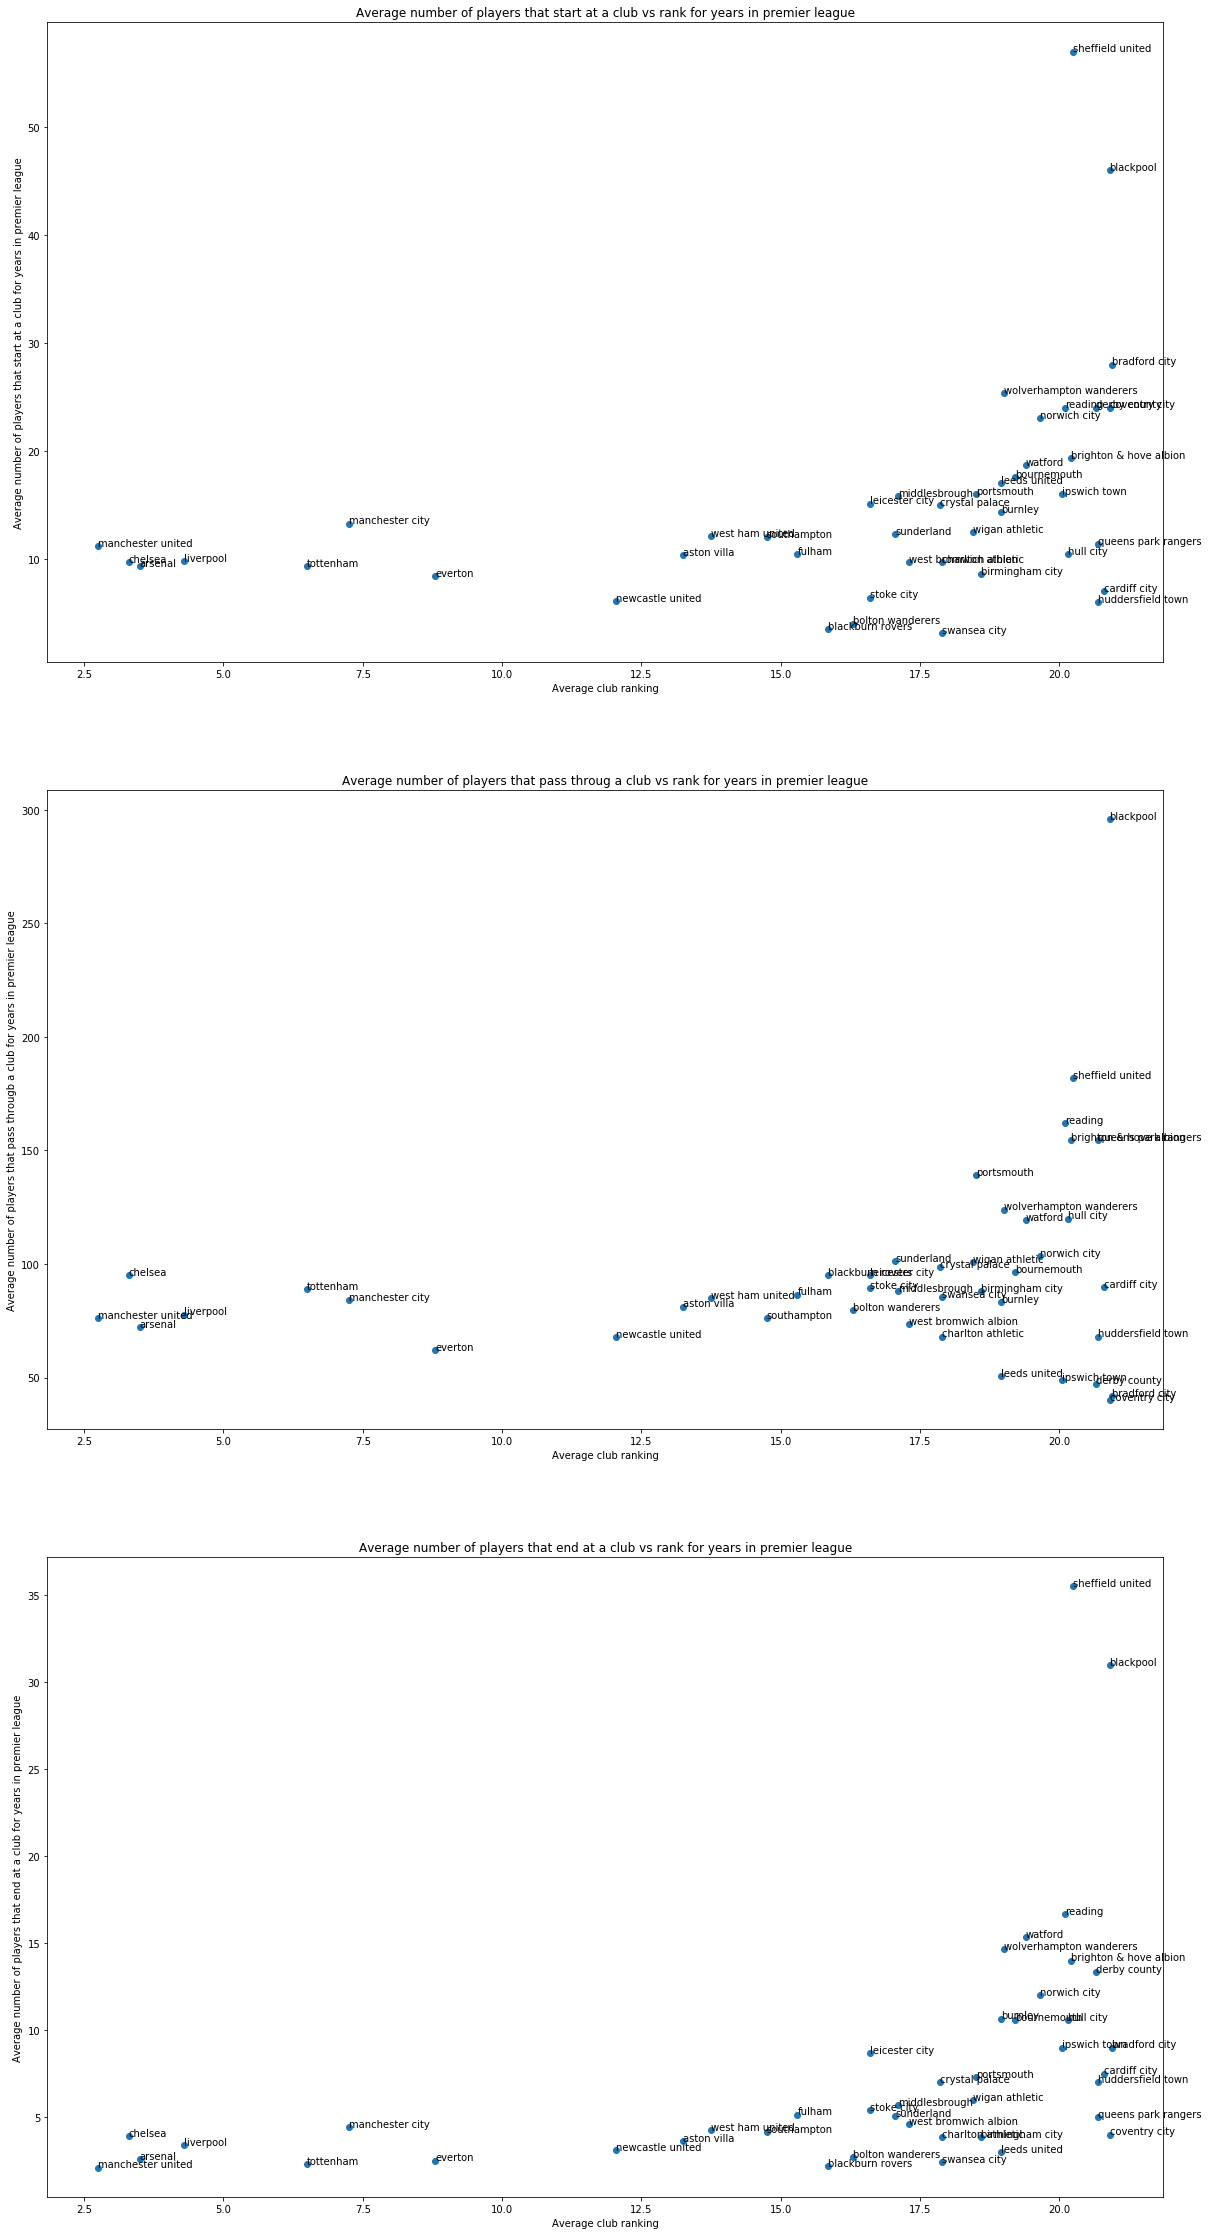

In [33]:
fig, axes = plt.subplots(3, 1, figsize=(20, 40))

for i, ax in enumerate(axes):
    
    # get the data for the x and y
    x = []
    y = []
    
    # keep track of clubs to ignore
    to_ignore = set()
    
    for k in shared_clubs[i]:
        # find the number of years they were in the premier league from start to end year
        years_in_pl = 0
        
        for year, rankings in prem_rankings.items():
            if k in rankings:
                years_in_pl += 1
                
        if years_in_pl == 0:
            to_ignore.add(k)
            
        else:
            x.append(avg_ranks[k])
            y.append(player_counts[i][k] / years_in_pl)
        
#     x = [avg_ranks[k] for k in shared_clubs[i]]
#     y = [player_counts[i][k] for k in shared_clubs[i]]
    
    ax.scatter(x, y)
    ax.set_xlabel('Average club ranking')
    ax.set_ylabel(y_labels[i])
    ax.set_title(titles[i])
    
    for j, club in enumerate(shared_clubs[i]):
        ax.annotate(club, (x[j], y[j]))